In [1]:
import sys
import pandas as pd
from pathlib import Path
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx

# Add project root to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import src.config as config

plt.ioff()

In [2]:
from src.loadProcessed import load_selected_count, load_processed_locations

counts = load_selected_count()
locations = load_processed_locations()

location_specific_stats = pd.read_parquet(config.PROCESSED_DATA_DIR / 'location_specific_stats.parquet')

loc_stats_wlocinfo = location_specific_stats.merge(
    locations[['sensor_id', 'sensor_description', 'latitude', 'longitude']],
    left_index=True,
    right_on='sensor_id',
    how='left'
)

population_stats = pd.read_parquet(config.PROCESSED_DATA_DIR / 'population_stats.parquet')

In [ ]:

from pyproj import Transformer
from matplotlib.colors import TwoSlopeNorm, Normalize

plot_data = loc_stats_wlocinfo.copy()
plot_data['magnitude'] = plot_data['percent_year_change'].abs()

# Convert lat/lon to Web Mercator (meters) for Contextily
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
plot_data['x'], plot_data['y'] = transformer.transform(plot_data['longitude'].values, plot_data['latitude'].values)

fig, ax = plt.subplots(figsize=(4, 8))

# Create Colormap with Two-Slope Normalization
cmap = mpl.colormaps['RdYlGn']

# Two-slope norm centers at 0
traffic_change_norm = TwoSlopeNorm(
    vmin=plot_data['percent_year_change'].min(),
    vcenter=0,
    vmax=plot_data['percent_year_change'].max()
)

# Scatter points
sc = ax.scatter(
    plot_data['x'], plot_data['y'],
    cmap=cmap, 
    c=plot_data['percent_year_change'],
    norm=traffic_change_norm,
    edgecolors='white',
    s= 50 * np.sqrt(plot_data['magnitude']),
    alpha=.9,
    zorder=2
)

# Add colourbar
cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', 
                    fraction=0.03, pad=0.01, aspect=30)
cbar.set_label('% Change in Pedestrian Traffic', fontsize=10)
cbar.outline.set_visible(False)

# Set limits with a small buffer
buffer = 500
ax.set_xlim(plot_data['x'].min() - buffer, plot_data['x'].max() + buffer)
ax.set_ylim(plot_data['y'].min() - buffer, plot_data['y'].max() + buffer)

ax.set_title('Percentage Change in Daily\nPedestrian Traffic from 2019 to 2025')

# Stops map from being stretched
ax.set_aspect('equal')

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

plt.tight_layout()
plt.show()

fig.savefig(config.WEBAPP_RESOURCES_DIR / "percent_change_plot.svg", transparent=True, bbox_inches='tight')

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(2, figsize=(4, 8))

total_change_norm = Normalize(
    vmin=pd.concat([plot_data['count_2019_estimate'], plot_data['count_2025_estimate']]).min(),
    vmax=pd.concat([plot_data['count_2019_estimate'], plot_data['count_2025_estimate']]).max()
)

# Scatter points
ax_1.scatter(
    plot_data['x'], plot_data['y'],
    cmap=cmap, 
    c=plot_data['count_2019_estimate'],
    norm=total_change_norm,
    edgecolors='white',
    s= 1.5 * np.sqrt(plot_data['count_2019_estimate']),
    alpha=.9,
    zorder=2
)

ax_2.scatter(
    plot_data['x'], plot_data['y'],
    cmap=cmap, 
    c=plot_data['count_2025_estimate'],
    norm=total_change_norm,
    edgecolors='white',
    s= 1.5 * np.sqrt(plot_data['count_2025_estimate']),
    alpha=.9,
    zorder=2
)


# Add colourbar
cbar = fig.colorbar(sc, ax=ax_2, orientation='horizontal', 
                    fraction=0.03, pad=0.01, aspect=30)
cbar.set_label('Average Daily Pedestrian Traffic', fontsize=10)
cbar.outline.set_visible(False)

# Set limits with a small buffer
buffer = 500
ax_1.set_xlim(plot_data['x'].min() - buffer, plot_data['x'].max() + buffer)
ax_1.set_ylim(plot_data['y'].min() - buffer, plot_data['y'].max() + buffer)

# Stops map from being stretched
ax_1.set_aspect('equal')

ax_1.set_title('Average Daily Pedestrian Traffic in 2019')

# Add basemap
cx.add_basemap(ax_1, source=cx.providers.CartoDB.Positron)
ax_1.set_axis_off()

ax_2.set_xlim(plot_data['x'].min() - buffer, plot_data['x'].max() + buffer)
ax_2.set_ylim(plot_data['y'].min() - buffer, plot_data['y'].max() + buffer)

# Stops map from being stretched
ax_2.set_aspect('equal')

ax_2.set_title('Average Daily Pedestrian Traffic in 2025')

# Add basemap
cx.add_basemap(ax_2, source=cx.providers.CartoDB.Positron)
ax_2.set_axis_off()


plt.tight_layout()
plt.show()

fig.savefig(config.WEBAPP_RESOURCES_DIR / "counts_map_plot.svg", transparent=True, bbox_inches='tight')

In [5]:
# Get RGB values at intermediate positions on the colormap [0, 1]
for pos in range(0, 10, 1):
    rgba = cmap(pos/10)
    rgb = [int(255*rgba[0]), int(255*rgba[1]), int(255*rgba[2])]
    print(f"Position {pos/10}: RGB={rgb}")

Position 0.0: RGB=[165, 0, 38]
Position 0.1: RGB=[214, 47, 38]
Position 0.2: RGB=[244, 109, 67]
Position 0.3: RGB=[252, 172, 96]
Position 0.4: RGB=[254, 224, 139]
Position 0.5: RGB=[254, 254, 189]
Position 0.6: RGB=[217, 239, 139]
Position 0.7: RGB=[164, 216, 105]
Position 0.8: RGB=[102, 189, 99]
Position 0.9: RGB=[25, 151, 79]


## Adding Colour

In [6]:
pydeck_data = loc_stats_wlocinfo.copy()
pydeck_data['count_difference_2025_2019'] = pydeck_data['count_2025_estimate'] - pydeck_data['count_2019_estimate']
pydeck_data['absolute_change'] = abs(pydeck_data['count_difference_2025_2019'])

In [7]:
# import cmasher as cmr
# import matplotlib.colors as mplcolors

# # Apply colourmap to data

# cmap = cmr.get_sub_cmap("cmr.prinsenvlag", 0.0, 1.0)
# # cmap = cmap.reversed()

# normalised_colour_map = mplcolors.Normalize(
#     vmin=pydeck_data['percent_year_change'].min(),
#     vcenter=0,
#     vmax=pydeck_data['percent_year_change'].max()
# )

# def cmr_to_rgb(value):
#     r, g, b, _ = cmap(normalised_colour_map(value))
#     return [int(255*r), int(255*g), int(255*b)]

# pydeck_data['colour'] = pydeck_data['percent_year_change'].apply(cmr_to_rgb)

In [8]:
def two_colour_map(pchange):
    if pchange > 0:
        return  [132, 202, 102]
    else:
        return [244, 109, 67]

pydeck_data['colour'] = pydeck_data['count_difference_2025_2019'].apply(
    two_colour_map
)

In [9]:
export_cols = [
    "longitude",
    "latitude",
    "count_difference_2025_2019",
    "absolute_change",
    "sensor_description",
    "colour",
    "sensor_id"
]

pydeck_data[export_cols].to_json(
    config.WEBAPP_RESOURCES_DIR / "pedestrian_data.json",
    orient="records"
)

## Graphing Sensor Plots

In [10]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

sensors = counts['sensor_id'].unique()

rgb_grn_frac = tuple(np.divide([132, 202, 102], 256))
rgb_blu_frac = tuple(np.divide([13, 110, 253], 256))

for s_id in sensors:
    
    sensor_location = locations[locations['sensor_id'] == s_id].squeeze()
    sensor_counts = counts[counts['sensor_id'] == s_id]

    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.set_title(f'Pedestrian Traffic at {sensor_location['sensor_description']}', fontsize=16, pad=20)

    sensor_counts_2019 = sensor_counts[sensor_counts['sensing_date'].dt.year == 2019]
    sensor_counts_2025 = sensor_counts[sensor_counts['sensing_date'].dt.year == 2025]

    ax.plot(
        sensor_counts_2019['sensing_date'].dt.day_of_year,
        sensor_counts_2019['daily_count'],
        color=rgb_blu_frac,
        alpha=0.8,
        linewidth=2.5,
        label='2019'
    )
    ax.plot(
        sensor_counts_2025['sensing_date'].dt.day_of_year,
        sensor_counts_2025['daily_count'],
        color=rgb_grn_frac,
        alpha=0.8,
        linewidth=2.5,
        label='2025'
    )
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xlim(0, 370)
    ax.set_xlabel('Day of the year', fontsize=12)
    ax.set_ylabel('Daily pedestrian count', fontsize=12)

    ax.legend(fontsize=11, loc='upper left', framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    fig.savefig(config.WEBAPP_RESOURCES_DIR / 'sensorplots' / f"{s_id}_sensor_plot.svg", transparent=True, bbox_inches='tight')

    plt.close()

## Plotting Day Effects

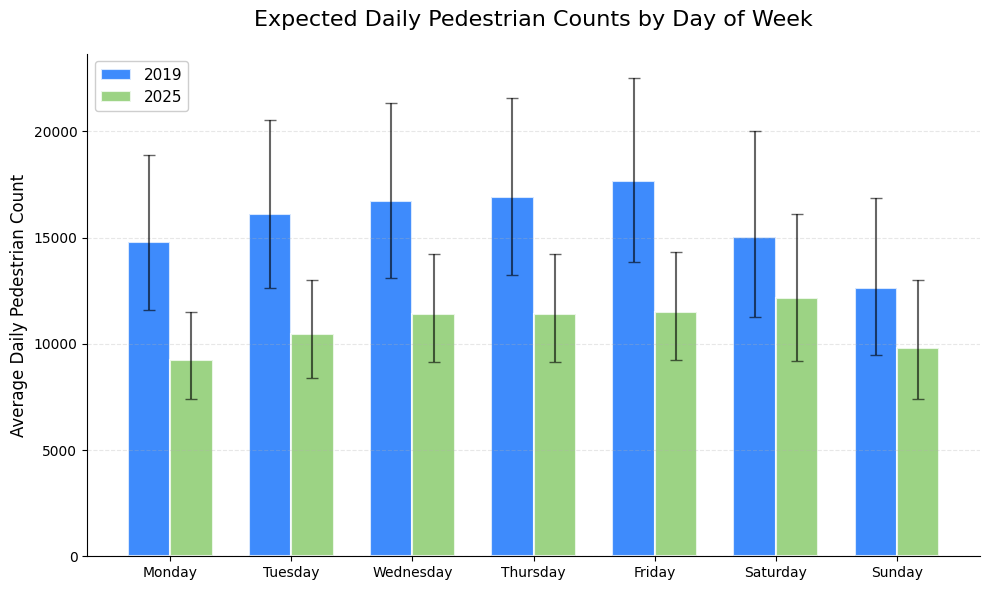

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Use your existing color scheme
rgb_grn_frac = tuple(np.divide([132, 202, 102], 256))
rgb_blu_frac = tuple(np.divide([13, 110, 253], 256))

# Extract data for both years
est_2019 = [population_stats.loc['estimate', f'{day}_expected_2019'] for day in days]
est_2025 = [population_stats.loc['estimate', f'{day}_expected_2025'] for day in days]

lower_2019 = [population_stats.loc['lower', f'{day}_expected_2019'] for day in days]
upper_2019 = [population_stats.loc['upper', f'{day}_expected_2019'] for day in days]

lower_2025 = [population_stats.loc['lower', f'{day}_expected_2025'] for day in days]
upper_2025 = [population_stats.loc['upper', f'{day}_expected_2025'] for day in days]

# Calculate error bar sizes (distance from estimate to CI bounds)
err_2019 = [np.array(est_2019) - np.array(lower_2019), np.array(upper_2019) - np.array(est_2019)]
err_2025 = [np.array(est_2025) - np.array(lower_2025), np.array(upper_2025) - np.array(est_2025)]

# Set up bar positions
x = np.arange(len(days))
width = 0.35

# Create bars with error bars
bars1 = ax.bar(x - width/2, est_2019, width, label='2019', 
               color=rgb_blu_frac, alpha=0.8, edgecolor='white', linewidth=1.5,
               yerr=err_2019, capsize=4, error_kw={'alpha': 0.6})

bars2 = ax.bar(x + width/2, est_2025, width, label='2025', 
               color=rgb_grn_frac, alpha=0.8, edgecolor='white', linewidth=1.5,
               yerr=err_2025, capsize=4, error_kw={'alpha': 0.6})

ax.set_title('Expected Daily Pedestrian Counts by Day of Week', fontsize=16, pad=20)
ax.set_ylabel('Average Daily Pedestrian Count', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(days)
ax.set_ylim(0, max(upper_2019)* 1.05)

ax.legend(fontsize=11, loc='upper left', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# fig.savefig(config.WEBAPP_RESOURCES_DIR / "day_effects.svg", transparent=True, bbox_inches='tight')

In [ ]:
weekend_change = population_stats['wknd_']